### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Tue Oct  7 08:22:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [ ]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 91.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.8/89.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 116.2 MB/s eta 0:00:00


### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

## Download dataset from Roboflow Universe

In [ ]:

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="sftb2kqF6QOrME6vZXEg")
project = rf.workspace("ppe-ujjwv").project("ppe-rigs-pdsi")
version = project.version(2)
dataset = version.download("yolov12")



loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ppe-rigs-pdsi-2 in yolov12:: 100%|██████████| 5852/5852 [00:01<00:00, 5120.26it/s]


In [ ]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [ ]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [ ]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 11
names: ['boots', 'gloves', 'goggles', 'helmet', 'no-helm', 'no_glove', 'no_goggles', 'no_helmet', 'no_shoes', 'person', 'vest']

roboflow:
  workspace: ppe-ujjwv
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
New https://pypi.org/project/ultralytics/8.3.205 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/ppe-rigs-pdsi-2/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, 

100%|██████████| 755k/755k [00:00<00:00, 26.9MB/s]


Overriding model.yaml nc=80 with nc=11

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytic

100%|██████████| 5.26M/5.26M [00:00<00:00, 114MB/s]


AMP: checks passed ✅


train: Scanning /content/ppe-rigs-pdsi-2/train/labels... 2119 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2119/2119 [00:00<00:00, 2343.52it/s]


train: New cache created: /content/ppe-rigs-pdsi-2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/ppe-rigs-pdsi-2/valid/labels... 657 images, 0 backgrounds, 0 corrupt: 100%|██████████| 657/657 [00:00<00:00, 973.63it/s] 


val: New cache created: /content/ppe-rigs-pdsi-2/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.77G      3.775       4.76      4.162         36        640: 100%|██████████| 133/133 [01:36<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:23<00:00,  1.11s/it]

                   all        657       3750      0.643      0.071    0.00472    0.00163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.68G      3.222      4.029      3.455         87        640: 100%|██████████| 133/133 [01:11<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.29it/s]

                   all        657       3750      0.196     0.0924    0.00866    0.00304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.87G      2.804      3.264      2.849         57        640: 100%|██████████| 133/133 [01:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.41it/s]


                   all        657       3750      0.547      0.157      0.159     0.0707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.88G      2.527      2.877      2.521         68        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.24it/s]

                   all        657       3750      0.595       0.15      0.183     0.0849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.75G      2.344      2.642      2.326         65        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.33it/s]

                   all        657       3750      0.709      0.191      0.217      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.73G      2.204      2.444      2.189         55        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.44it/s]


                   all        657       3750      0.676      0.198      0.248      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.89G      2.092      2.293      2.058         67        640: 100%|██████████| 133/133 [01:09<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.40it/s]

                   all        657       3750      0.774      0.232      0.283      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.86G      1.971      2.095      1.935         54        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]

                   all        657       3750      0.532      0.264      0.298      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.88G      1.919      1.986       1.88         64        640: 100%|██████████| 133/133 [01:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.51it/s]

                   all        657       3750      0.699      0.272      0.315      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.86G      1.858      1.924      1.826         66        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.34it/s]


                   all        657       3750      0.725      0.281      0.327      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.71G      1.801      1.831      1.776         78        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.39it/s]

                   all        657       3750      0.706      0.293       0.34      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.84G      1.776      1.781      1.732         24        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.40it/s]

                   all        657       3750      0.727      0.301      0.355      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.91G      1.742      1.746       1.71         25        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.52it/s]

                   all        657       3750      0.707      0.305      0.346      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       6.9G      1.705      1.673      1.675         61        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.41it/s]

                   all        657       3750      0.679      0.323      0.358      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.86G      1.699      1.641      1.656         46        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.41it/s]

                   all        657       3750      0.648      0.343      0.377      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.87G      1.653      1.592      1.623         46        640: 100%|██████████| 133/133 [01:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.47it/s]

                   all        657       3750      0.562      0.333      0.368       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.88G      1.631      1.567      1.618         47        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.49it/s]

                   all        657       3750      0.657      0.352      0.386      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       6.7G      1.613      1.509      1.578         47        640: 100%|██████████| 133/133 [01:10<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.39it/s]

                   all        657       3750      0.678      0.345      0.389      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.87G      1.593      1.489      1.572         73        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.43it/s]

                   all        657       3750      0.542      0.364       0.39      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.84G      1.578      1.474      1.562         40        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.46it/s]

                   all        657       3750      0.645      0.349      0.392      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.86G      1.554      1.436      1.542         60        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.54it/s]

                   all        657       3750      0.686      0.368      0.411      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       6.7G      1.545      1.442      1.546         39        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.31it/s]

                   all        657       3750      0.706      0.354      0.404      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.88G      1.509      1.393      1.511         60        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.41it/s]

                   all        657       3750      0.696      0.363      0.415       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.83G      1.516      1.393      1.517         58        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]

                   all        657       3750      0.665      0.383      0.419      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       6.9G      1.501      1.358      1.503         71        640: 100%|██████████| 133/133 [01:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.54it/s]

                   all        657       3750      0.632      0.395      0.423      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.71G      1.496      1.355      1.496         47        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]


                   all        657       3750      0.655      0.401      0.432      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       6.7G      1.461        1.3       1.47         58        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.44it/s]

                   all        657       3750      0.662      0.377      0.424       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.87G      1.456      1.297      1.459         93        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.27it/s]

                   all        657       3750      0.694      0.381       0.43      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.87G      1.459      1.282      1.451         55        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.54it/s]

                   all        657       3750      0.708      0.384       0.44      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.69G      1.442       1.26      1.446         49        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]

                   all        657       3750      0.671      0.396      0.435      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       6.7G       1.43      1.259      1.437         48        640: 100%|██████████| 133/133 [01:10<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.39it/s]

                   all        657       3750      0.664      0.411      0.445      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.83G      1.406      1.215      1.419         86        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]

                   all        657       3750      0.684      0.406      0.443      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.72G      1.398      1.222      1.411         48        640: 100%|██████████| 133/133 [01:10<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.54it/s]

                   all        657       3750      0.657      0.405      0.439      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.72G      1.416      1.217       1.41         38        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.31it/s]

                   all        657       3750      0.681      0.418       0.45      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.91G      1.388      1.193      1.399         51        640: 100%|██████████| 133/133 [01:10<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.41it/s]

                   all        657       3750      0.673      0.399      0.442      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.88G      1.395      1.211      1.413         51        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.43it/s]

                   all        657       3750      0.579      0.433      0.457      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       6.9G      1.389      1.182      1.394         48        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.51it/s]

                   all        657       3750      0.676      0.415      0.453      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       6.7G      1.357      1.167      1.385         60        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.43it/s]

                   all        657       3750      0.683      0.411      0.457      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.86G       1.37      1.156      1.398        113        640: 100%|██████████| 133/133 [01:10<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.44it/s]

                   all        657       3750      0.708      0.426      0.471      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.85G      1.345      1.145      1.376         27        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.43it/s]

                   all        657       3750      0.681      0.391      0.445      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100       6.7G       1.34      1.132      1.368        115        640: 100%|██████████| 133/133 [01:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.50it/s]

                   all        657       3750      0.669      0.417      0.462      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.88G      1.341      1.124      1.363         85        640: 100%|██████████| 133/133 [01:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.53it/s]

                   all        657       3750      0.681      0.432      0.463      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.69G      1.325      1.116      1.358         67        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.41it/s]

                   all        657       3750      0.668       0.44       0.47      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.87G      1.338      1.118      1.366         40        640: 100%|██████████| 133/133 [01:09<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.42it/s]

                   all        657       3750      0.691      0.435      0.473      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.88G       1.32      1.105      1.354         97        640: 100%|██████████| 133/133 [01:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.54it/s]

                   all        657       3750      0.684      0.429      0.474      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       6.9G      1.305      1.096      1.349         54        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.40it/s]

                   all        657       3750      0.597      0.459      0.479       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       6.9G      1.304      1.088      1.341         77        640: 100%|██████████| 133/133 [01:10<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.44it/s]

                   all        657       3750       0.68      0.441      0.475      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.87G      1.299      1.072      1.336         42        640: 100%|██████████| 133/133 [01:10<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.43it/s]

                   all        657       3750      0.657      0.467      0.486      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       6.7G        1.3      1.068      1.327         64        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.42it/s]

                   all        657       3750        0.7      0.441      0.476      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.87G      1.273      1.049      1.326         42        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.56it/s]

                   all        657       3750      0.689      0.435      0.475      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       6.7G       1.27      1.046      1.315         46        640: 100%|██████████| 133/133 [01:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.41it/s]

                   all        657       3750      0.703      0.456      0.488      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.84G      1.287      1.071       1.34         79        640: 100%|██████████| 133/133 [01:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]

                   all        657       3750      0.581      0.456      0.479      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.88G      1.267      1.039      1.311         48        640: 100%|██████████| 133/133 [01:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.53it/s]

                   all        657       3750      0.662      0.446      0.476      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       6.7G      1.231      1.009      1.298         54        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.51it/s]

                   all        657       3750      0.707      0.444      0.484      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.86G      1.256      1.016      1.296         48        640: 100%|██████████| 133/133 [01:10<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.43it/s]

                   all        657       3750      0.678      0.454      0.484      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.88G      1.254       1.02      1.302         80        640: 100%|██████████| 133/133 [01:10<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.41it/s]

                   all        657       3750      0.604      0.469      0.483      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.73G       1.24      1.007      1.298         83        640: 100%|██████████| 133/133 [01:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.51it/s]

                   all        657       3750      0.679      0.458      0.489      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.71G      1.232     0.9741      1.292         44        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.49it/s]

                   all        657       3750      0.714      0.454      0.494      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.85G      1.244       1.01      1.288         56        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.42it/s]

                   all        657       3750      0.599      0.462      0.485      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       6.9G      1.228     0.9927      1.288         52        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.43it/s]

                   all        657       3750      0.709      0.444       0.49       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.88G      1.221     0.9814      1.283         63        640: 100%|██████████| 133/133 [01:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.41it/s]

                   all        657       3750      0.717      0.446      0.496      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.86G      1.207      0.965       1.28         98        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.56it/s]

                   all        657       3750      0.613      0.486      0.499      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.86G      1.216     0.9847      1.285        100        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.41it/s]

                   all        657       3750      0.711      0.458      0.495      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.88G      1.219     0.9753      1.279         37        640: 100%|██████████| 133/133 [01:10<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.44it/s]

                   all        657       3750      0.616       0.46      0.498      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.87G      1.213     0.9685      1.276         34        640: 100%|██████████| 133/133 [01:10<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.26it/s]

                   all        657       3750      0.733      0.447      0.488      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.71G       1.19     0.9572      1.262         37        640: 100%|██████████| 133/133 [01:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.54it/s]

                   all        657       3750      0.723      0.452      0.497      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.85G       1.18     0.9389       1.26         73        640: 100%|██████████| 133/133 [01:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.42it/s]

                   all        657       3750      0.711      0.467        0.5      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.85G      1.199     0.9491      1.261         84        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.45it/s]

                   all        657       3750       0.73      0.459      0.499       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.73G      1.179     0.9393      1.263         36        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.42it/s]

                   all        657       3750      0.711      0.458      0.501       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.88G      1.186      0.934      1.258         36        640: 100%|██████████| 133/133 [01:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.56it/s]

                   all        657       3750      0.719      0.452      0.497      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.86G      1.188     0.9364      1.252         50        640: 100%|██████████| 133/133 [01:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.43it/s]

                   all        657       3750      0.727       0.45        0.5      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.84G      1.183     0.9459      1.255         61        640: 100%|██████████| 133/133 [01:10<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.43it/s]

                   all        657       3750      0.716      0.464      0.502      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.72G       1.17     0.9286      1.247         50        640: 100%|██████████| 133/133 [01:10<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.43it/s]

                   all        657       3750      0.717      0.458        0.5      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.91G      1.165     0.9205      1.249         57        640: 100%|██████████| 133/133 [01:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.52it/s]

                   all        657       3750      0.629      0.466      0.506      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.72G      1.155     0.9065      1.249         38        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.52it/s]

                   all        657       3750      0.724      0.462      0.505       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.86G      1.138     0.9054      1.244         81        640: 100%|██████████| 133/133 [01:10<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.42it/s]

                   all        657       3750      0.704      0.468      0.504      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.91G      1.154     0.9045       1.24         99        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.43it/s]

                   all        657       3750      0.727       0.46      0.505      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.75G      1.157     0.9057      1.242         43        640: 100%|██████████| 133/133 [01:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]

                   all        657       3750      0.727      0.464      0.503      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.69G       1.13     0.8826       1.23         54        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.57it/s]

                   all        657       3750      0.736      0.466      0.511      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.85G       1.15     0.8968      1.231         47        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.55it/s]

                   all        657       3750      0.625      0.469      0.508      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.87G      1.141     0.8892      1.228         37        640: 100%|██████████| 133/133 [01:10<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.39it/s]

                   all        657       3750      0.711       0.48       0.51      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.69G      1.132     0.8815      1.227         60        640: 100%|██████████| 133/133 [01:10<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.46it/s]

                   all        657       3750      0.689      0.489      0.512      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.86G       1.15     0.8919      1.235         55        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.46it/s]

                   all        657       3750      0.725      0.473      0.519      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.86G      1.131     0.8768      1.224         45        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.57it/s]

                   all        657       3750       0.73      0.469      0.515      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.73G      1.122     0.8758      1.218         70        640: 100%|██████████| 133/133 [01:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.51it/s]

                   all        657       3750      0.645      0.481      0.512       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.73G      1.121     0.8657      1.212        113        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.39it/s]

                   all        657       3750      0.515      0.491      0.511      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.69G       1.12      0.857      1.217         34        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.43it/s]

                   all        657       3750      0.727      0.466      0.515       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.84G      1.087     0.8485       1.21         87        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.44it/s]

                   all        657       3750      0.718      0.467      0.509      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.75G      1.099     0.8543      1.215         88        640: 100%|██████████| 133/133 [01:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.52it/s]

                   all        657       3750      0.621      0.483      0.518      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.91G       1.11     0.8633      1.208         44        640: 100%|██████████| 133/133 [01:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.43it/s]

                   all        657       3750      0.643      0.485      0.517      0.343


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.86G        1.1     0.8323      1.223         36        640: 100%|██████████| 133/133 [01:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.44it/s]

                   all        657       3750      0.635      0.481      0.511      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.83G      1.078     0.8101      1.217         23        640: 100%|██████████| 133/133 [01:09<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.57it/s]

                   all        657       3750      0.725      0.473      0.517      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.74G       1.06     0.7873      1.202         50        640: 100%|██████████| 133/133 [01:09<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.45it/s]

                   all        657       3750      0.734      0.468      0.513       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.87G      1.055     0.7827      1.201         27        640: 100%|██████████| 133/133 [01:09<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.34it/s]

                   all        657       3750       0.73      0.474      0.516      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.87G      1.054     0.7864      1.202         47        640: 100%|██████████| 133/133 [01:09<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.44it/s]

                   all        657       3750      0.721      0.474      0.516      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.86G      1.041     0.7687      1.192         55        640: 100%|██████████| 133/133 [01:09<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.48it/s]

                   all        657       3750      0.727      0.475      0.518      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.92G      1.046     0.7799       1.19         52        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.53it/s]

                   all        657       3750      0.731      0.468      0.515      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.86G      1.045     0.7755      1.193         34        640: 100%|██████████| 133/133 [01:09<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.39it/s]

                   all        657       3750      0.732      0.472       0.52      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.87G      1.037     0.7707      1.183         36        640: 100%|██████████| 133/133 [01:10<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.44it/s]

                   all        657       3750      0.739      0.473      0.521      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.87G      1.039     0.7667       1.19         34        640: 100%|██████████| 133/133 [01:09<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.39it/s]

                   all        657       3750      0.732      0.474      0.518      0.345



100 epochs completed in 2.240 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,078,465 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


                   all        657       3750      0.737      0.473      0.521      0.345
                 boots        411        953      0.873      0.834      0.902       0.62
                gloves        126        207      0.723      0.415      0.469      0.288
               goggles         16         33          1          0      0.103     0.0354
                helmet        490        780      0.834      0.828      0.877      0.596
               no-helm          3          3          0          0          0          0
              no_glove         70        231      0.552      0.316      0.372      0.137
            no_goggles         71        215      0.599      0.367      0.393      0.138
             no_helmet         35        187      0.828      0.568      0.689      0.375
              no_shoes          6         15          1          0    0.00778    0.00246
                person        382        452      0.798      0.908      0.952      0.845
                  ves

## Evaluate fine-tuned YOLOv12 model

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   train_batch11970.jpg
confusion_matrix_normalized.png			   train_batch11971.jpg
confusion_matrix.png				   train_batch11972.jpg
events.out.tfevents.1759825398.e90e7cf00f6d.398.0  train_batch1.jpg
F1_curve.png					   train_batch2.jpg
labels_correlogram.jpg				   val_batch0_labels.jpg
labels.jpg					   val_batch0_pred.jpg
P_curve.png					   val_batch1_labels.jpg
PR_curve.png					   val_batch1_pred.jpg
R_curve.png					   val_batch2_labels.jpg
results.csv					   val_batch2_pred.jpg
results.png					   weights
train_batch0.jpg


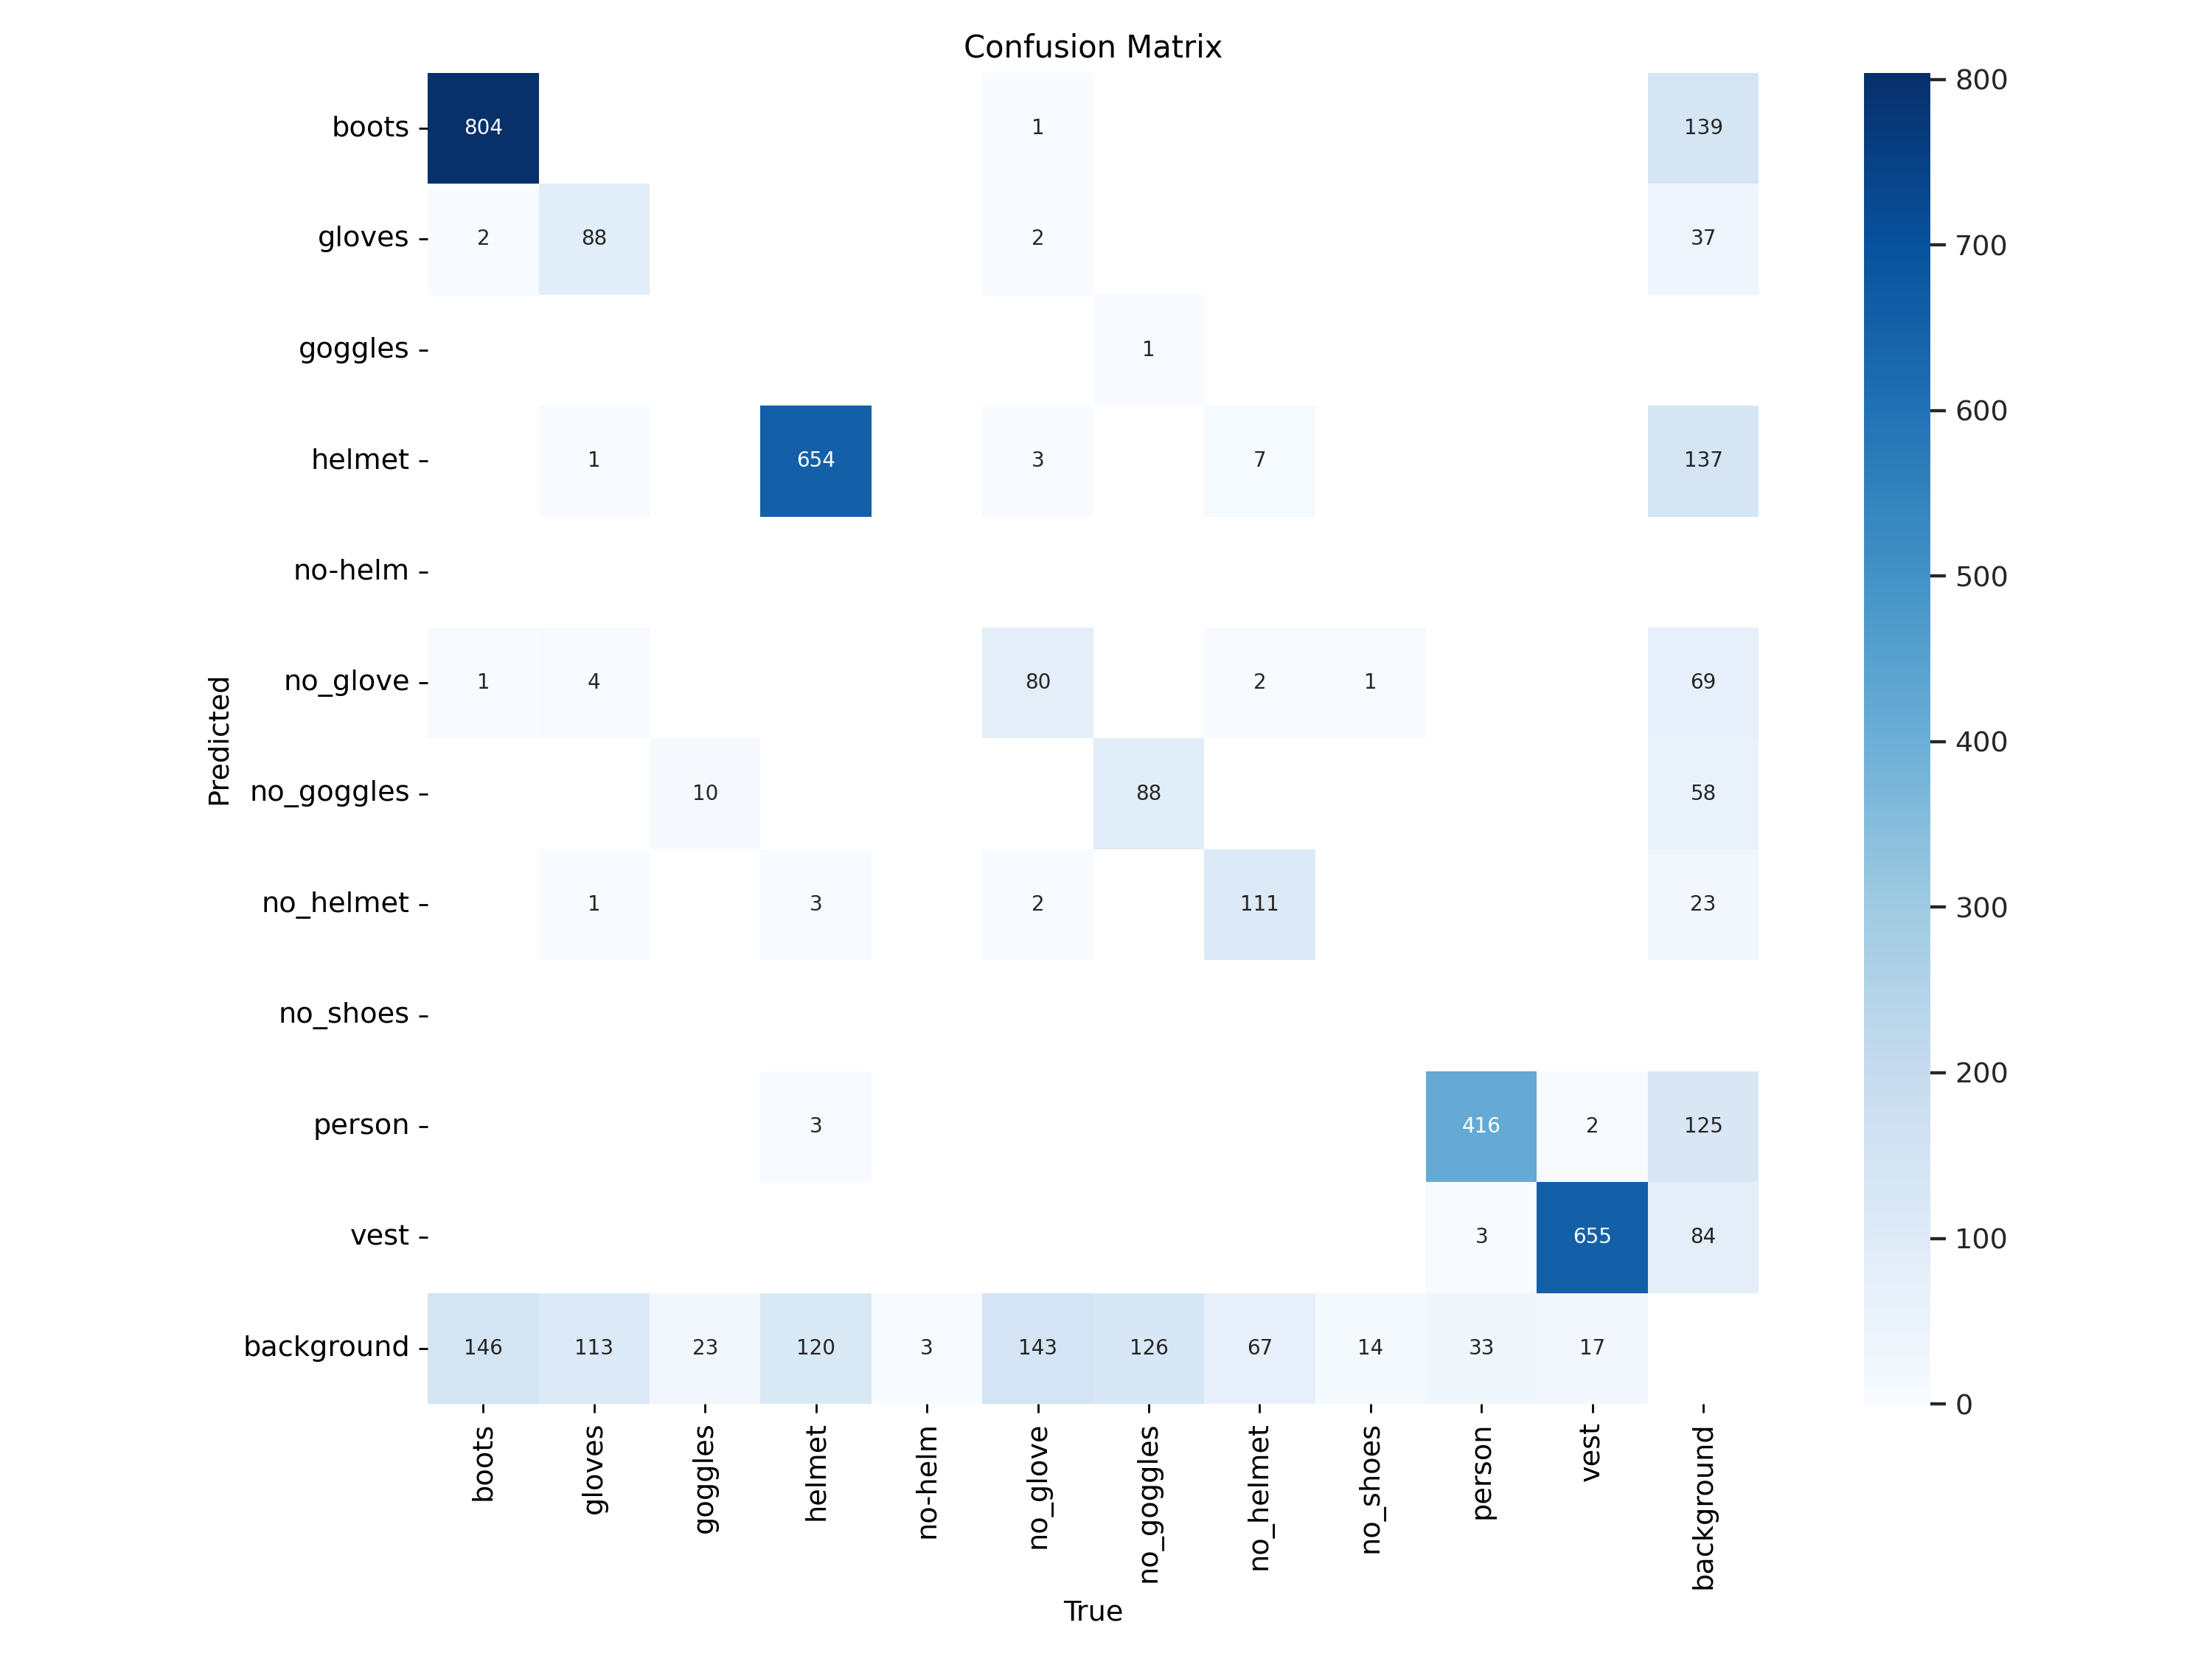

In [ ]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

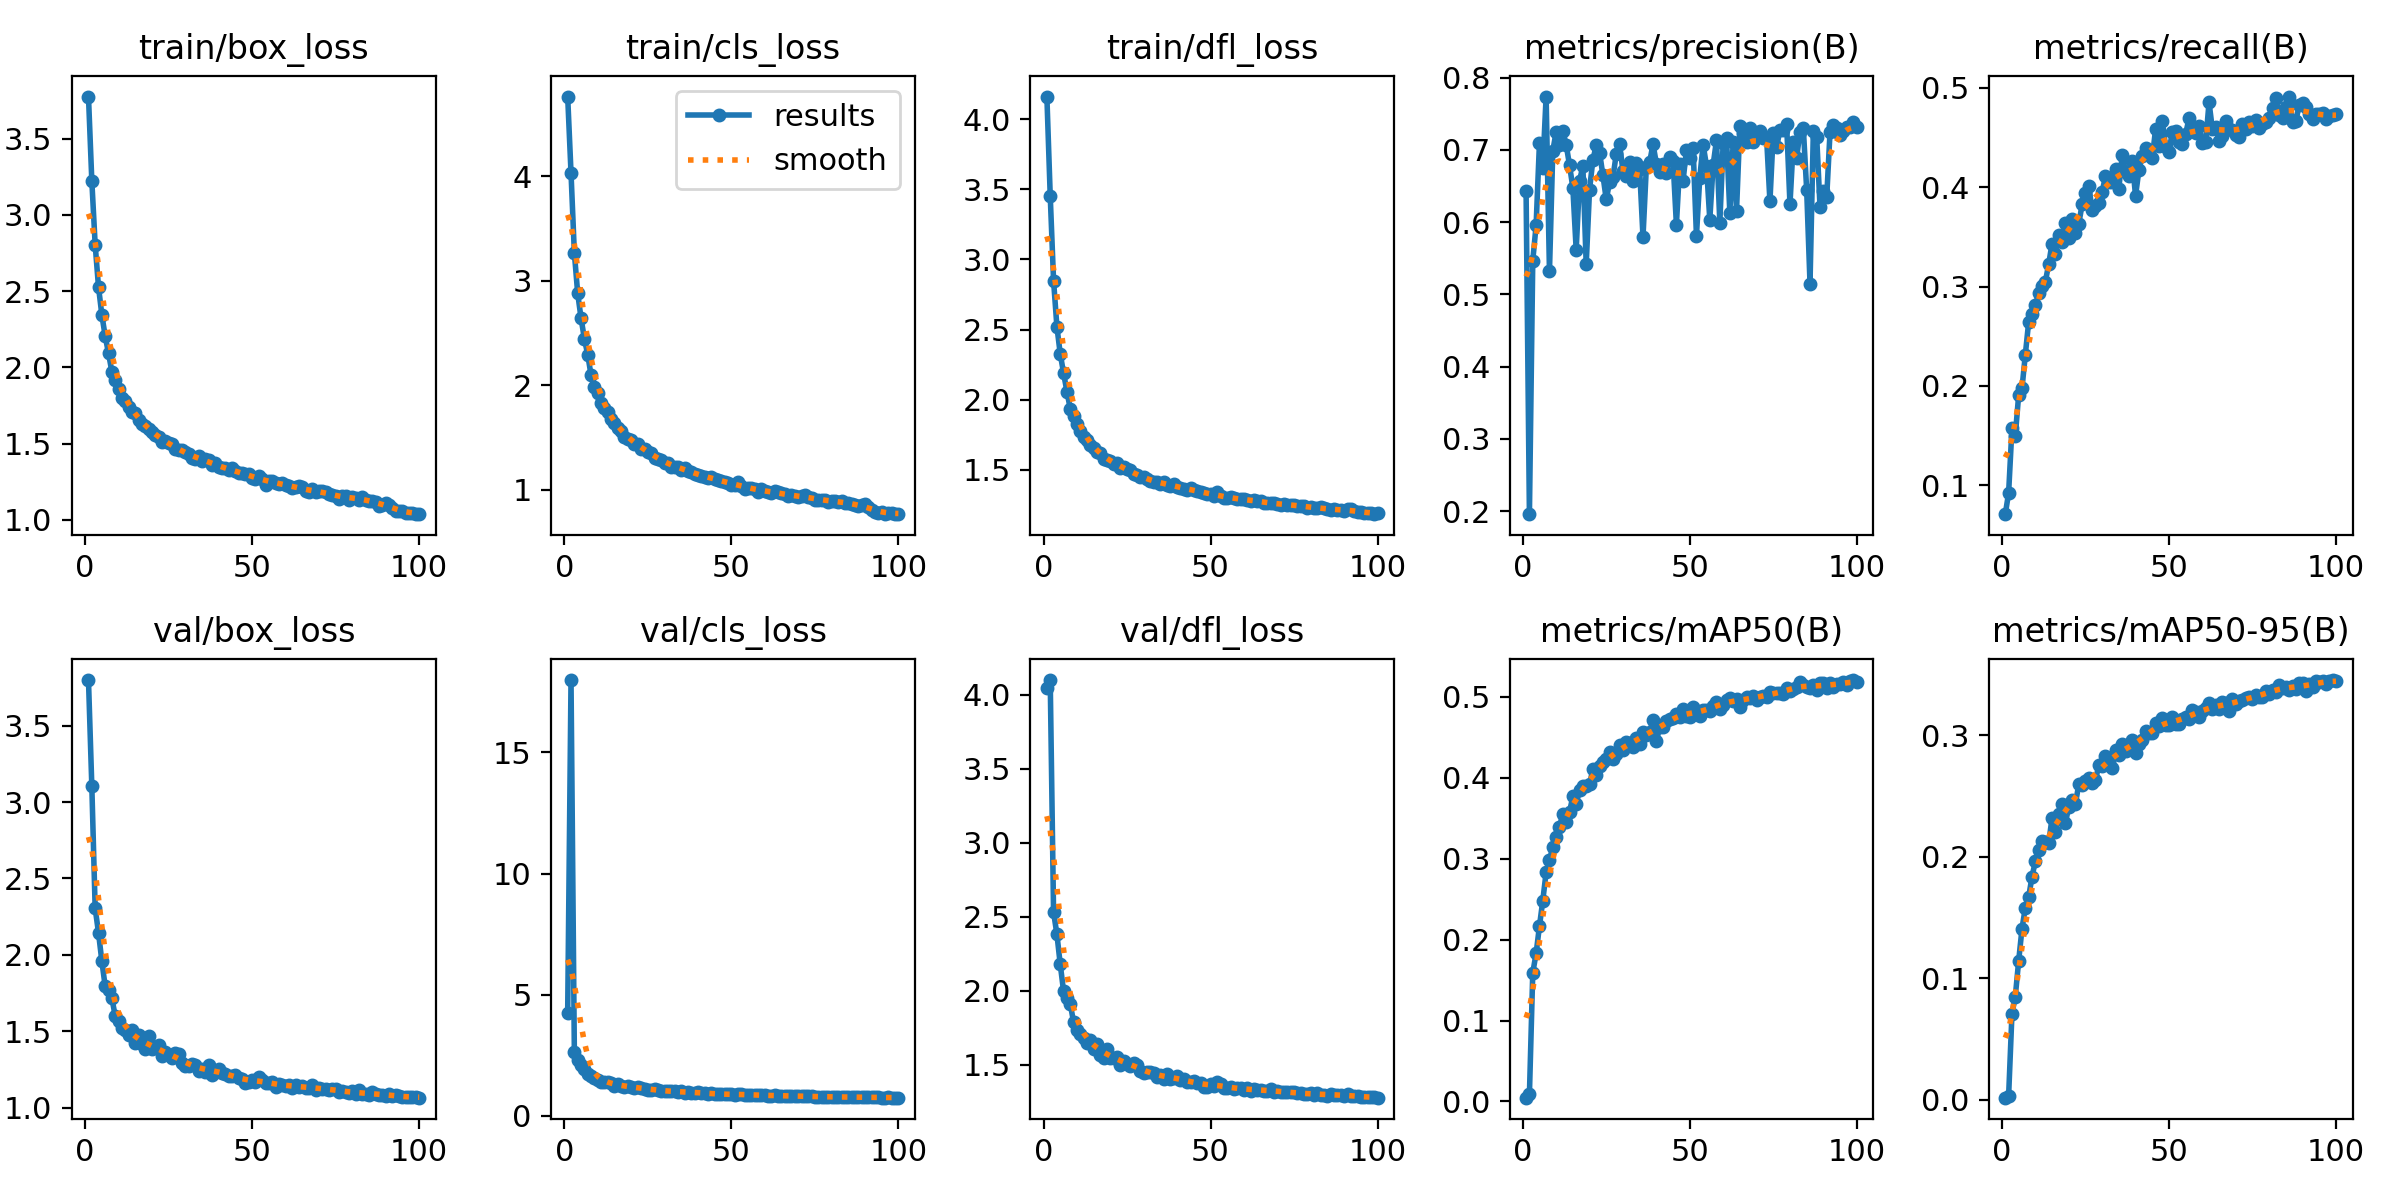

In [ ]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['boots',
 'gloves',
 'goggles',
 'helmet',
 'no-helm',
 'no_glove',
 'no_goggles',
 'no_helmet',
 'no_shoes',
 'person',
 'vest']

In [ ]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [ ]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.19331288901849514
mAP 50 0.34436773676748567
mAP 75 0.1899039238472436


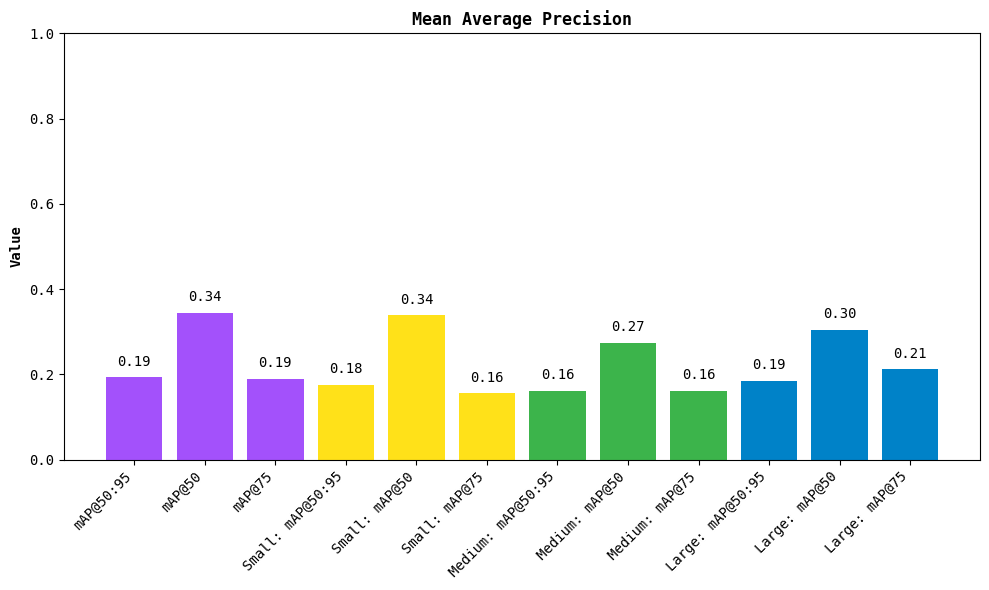

In [ ]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [ ]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

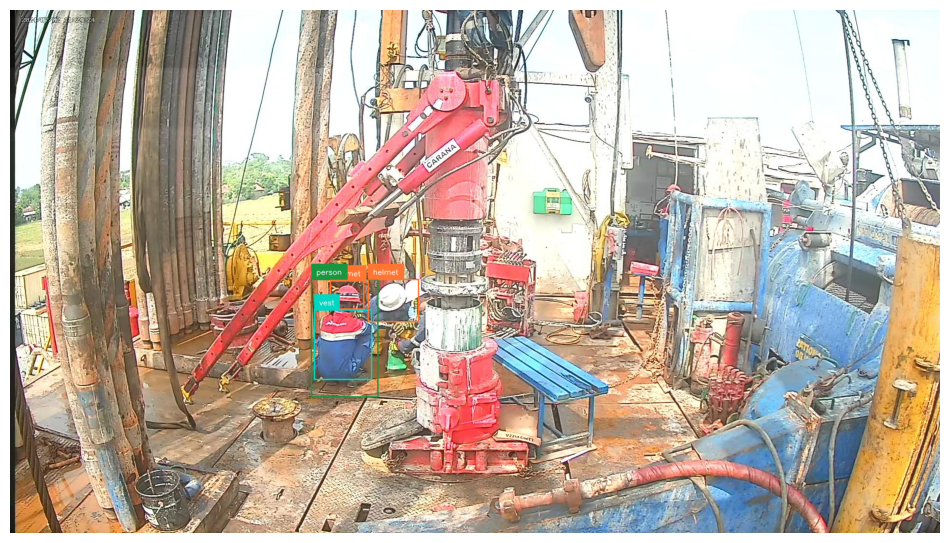

In [ ]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)